In [1]:

# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap


2025-01-14 15:27:27.590030: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 15:27:27.608750: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 15:27:27.754097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 15:27:27.755088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 15:27:28.353817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Step 1: Data Loading
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]


In [3]:

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

In [4]:
# Step 2: Data Preprocessing
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

In [5]:
# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:

# Step 3: Define TabTransformer Model
# Embedding dimensions
embedding_dim = 32
num_heads = 4
num_transformer_blocks = 2

In [7]:
def build_tabtransformer_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # Add a sequence length dimension (e.g., sequence length = 1)
    x = tf.expand_dims(inputs, axis=1)  # Shape becomes (batch_size, 1, input_dim)

    # Transformer Encoder Block
    x = layers.Dense(embedding_dim, activation="relu")(x)
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(embedding_dim, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)

    # Output Layer
    x = layers.GlobalAveragePooling1D()(x)  # Removes sequence length dimension
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# Build the model
model = build_tabtransformer_model(x_train.shape[1])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 41)]                 0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 1, 41)                0         ['input_1[0][0]']             
 )                                                                                                
                                                                                                  
 dense (Dense)               (None, 1, 32)                1344      ['tf.expand_dims[0][0]']      
                                                                                                  
 multi_head_attention (Mult  (None, 1, 32)                16800     ['dense[0][0]',           

2025-01-14 15:27:31.231575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-14 15:27:31.240654: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
# Step 4: Train the Model
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val)
)


Epoch 1/20
1575/1575 [==============================] - 5s 3ms/step - loss: 0.0585 - accuracy: 0.9778 - val_loss: 0.0344 - val_accuracy: 0.9875
Epoch 2/20
1575/1575 [==============================] - 4s 2ms/step - loss: 0.0321 - accuracy: 0.9879 - val_loss: 0.0259 - val_accuracy: 0.9910
Epoch 3/20
1575/1575 [==============================] - 4s 2ms/step - loss: 0.0274 - accuracy: 0.9898 - val_loss: 0.0303 - val_accuracy: 0.9884
Epoch 4/20
1575/1575 [==============================] - 3s 2ms/step - loss: 0.0253 - accuracy: 0.9907 - val_loss: 0.0232 - val_accuracy: 0.9915
Epoch 5/20
1575/1575 [==============================] - 4s 2ms/step - loss: 0.0230 - accuracy: 0.9917 - val_loss: 0.0224 - val_accuracy: 0.9933
Epoch 6/20
1575/1575 [==============================] - 4s 3ms/step - loss: 0.0227 - accuracy: 0.9922 - val_loss: 0.0209 - val_accuracy: 0.9929
Epoch 7/20
1575/1575 [==============================] - 4s 3ms/step - loss: 0.0210 - accuracy: 0.9924 - val_loss: 0.0192 - val_accuracy:

705/705 [==============================] - 1s 914us/step - loss: 1.6646 - accuracy: 0.7867
Test Loss: 1.6646064519882202, Test Accuracy: 0.7866837978363037


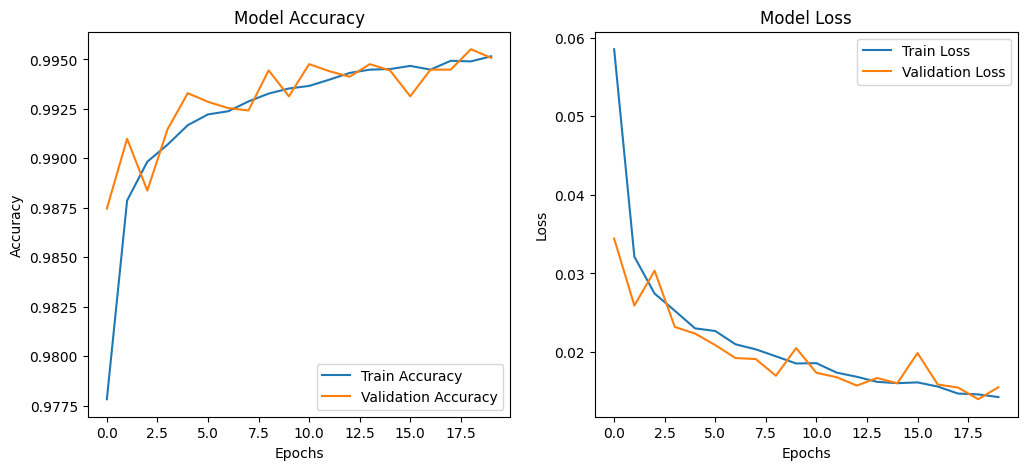

In [9]:
# Step 5: Evaluate the Model
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Step 6: Visualizations
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 1s 893us/step


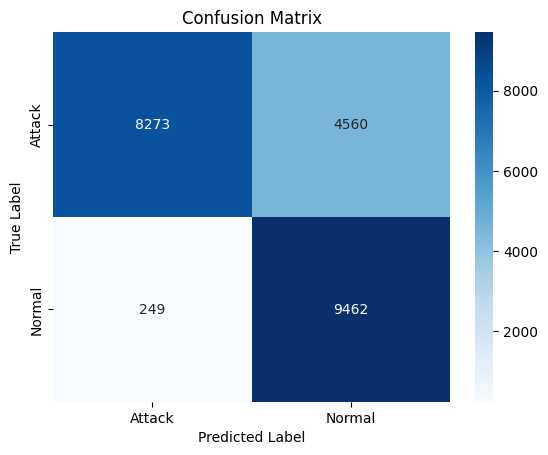

              precision    recall  f1-score   support

      Attack       0.97      0.64      0.77     12833
      Normal       0.67      0.97      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.78     22544



In [10]:
# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))



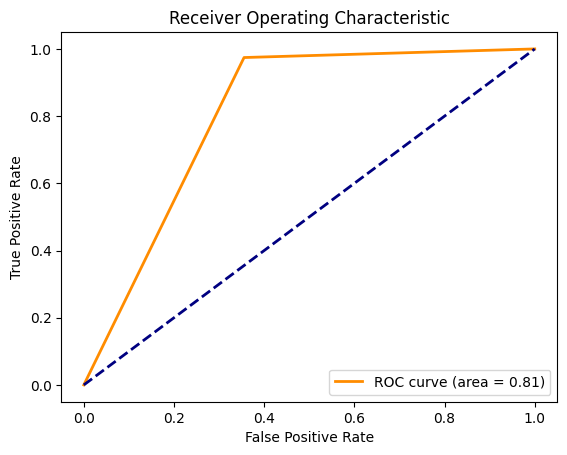

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()



In [ ]:
# Step 7: SHAP Analysis
# Explain predictions with SHAP
explainer = shap.KernelExplainer(model.predict, X_test[:100])  # Use a subset for SHAP due to compute constraints
shap_values = explainer.shap_values(X_test[:100])

# Summary Plot
shap.summary_plot(shap_values[0], X_test[:100], feature_names=train.columns[:-1])

# Force Plot (First Instance)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[:1], feature_names=train.columns[:-1])

# Feature Importance Plot
shap.summary_plot(shap_values, X_test[:100], plot_type="bar", feature_names=train.columns[:-1])


4/4 [==============================] - 0s 1ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6600/6600 [==============================] - 7s 1ms/step


  1%|          | 1/100 [00:08<14:02,  8.51s/it]

6600/6600 [==============================] - 6s 876us/step


  2%|▏         | 2/100 [00:15<12:00,  7.36s/it]

6600/6600 [==============================] - 5s 829us/step


  3%|▎         | 3/100 [00:21<11:04,  6.85s/it]

6600/6600 [==============================] - 6s 888us/step


  4%|▍         | 4/100 [00:27<10:49,  6.77s/it]

6600/6600 [==============================] - 6s 949us/step


  5%|▌         | 5/100 [00:35<10:53,  6.88s/it]

6600/6600 [==============================] - 6s 905us/step


  6%|▌         | 6/100 [00:41<10:43,  6.85s/it]

6600/6600 [==============================] - 5s 821us/step


  7%|▋         | 7/100 [00:48<10:17,  6.64s/it]

6600/6600 [==============================] - 6s 977us/step


  8%|▊         | 8/100 [00:55<10:27,  6.82s/it]

6600/6600 [==============================] - 6s 870us/step


  9%|▉         | 9/100 [01:01<10:12,  6.73s/it]

6600/6600 [==============================] - 8s 1ms/step


 10%|█         | 10/100 [01:10<10:51,  7.23s/it]

6600/6600 [==============================] - 6s 866us/step


 11%|█         | 11/100 [01:16<10:23,  7.01s/it]

6600/6600 [==============================] - 6s 892us/step


 12%|█▏        | 12/100 [01:23<10:10,  6.94s/it]

6600/6600 [==============================] - 6s 942us/step


 13%|█▎        | 13/100 [01:30<10:05,  6.96s/it]

6600/6600 [==============================] - 6s 910us/step


 14%|█▍        | 14/100 [01:37<09:53,  6.90s/it]

6600/6600 [==============================] - 6s 835us/step


 15%|█▌        | 15/100 [01:43<09:30,  6.71s/it]

6600/6600 [==============================] - 5s 813us/step


 16%|█▌        | 16/100 [01:49<09:08,  6.54s/it]

6600/6600 [==============================] - 5s 830us/step


 17%|█▋        | 17/100 [01:55<08:54,  6.45s/it]

6600/6600 [==============================] - 6s 837us/step


 18%|█▊        | 18/100 [02:02<08:44,  6.40s/it]

6600/6600 [==============================] - 6s 839us/step


 19%|█▉        | 19/100 [02:08<08:35,  6.37s/it]

6600/6600 [==============================] - 6s 844us/step


 20%|██        | 20/100 [02:14<08:28,  6.36s/it]

6600/6600 [==============================] - 5s 797us/step


 21%|██        | 21/100 [02:20<08:14,  6.26s/it]

6600/6600 [==============================] - 6s 848us/step


 22%|██▏       | 22/100 [02:27<08:10,  6.29s/it]

6600/6600 [==============================] - 6s 954us/step


 23%|██▎       | 23/100 [02:34<08:24,  6.55s/it]

6600/6600 [==============================] - 5s 794us/step


 24%|██▍       | 24/100 [02:40<08:05,  6.39s/it]

6600/6600 [==============================] - 11s 2ms/step


 25%|██▌       | 25/100 [02:52<10:07,  8.10s/it]

6600/6600 [==============================] - 6s 947us/step


 26%|██▌       | 26/100 [02:59<09:37,  7.81s/it]

6600/6600 [==============================] - 6s 935us/step


 27%|██▋       | 27/100 [03:06<09:12,  7.57s/it]

6600/6600 [==============================] - 6s 953us/step


 28%|██▊       | 28/100 [03:13<08:56,  7.45s/it]

6600/6600 [==============================] - 6s 876us/step


 29%|██▉       | 29/100 [03:20<08:30,  7.20s/it]

6600/6600 [==============================] - 5s 809us/step


 30%|███       | 30/100 [03:26<08:00,  6.86s/it]

6600/6600 [==============================] - 6s 898us/step


 31%|███       | 31/100 [03:33<07:50,  6.81s/it]

6600/6600 [==============================] - 6s 928us/step


 32%|███▏      | 32/100 [03:39<07:45,  6.84s/it]

6600/6600 [==============================] - 6s 931us/step


 33%|███▎      | 33/100 [03:46<07:39,  6.86s/it]

6600/6600 [==============================] - 7s 994us/step


 34%|███▍      | 34/100 [03:54<07:44,  7.04s/it]

6600/6600 [==============================] - 6s 851us/step


 35%|███▌      | 35/100 [04:00<07:24,  6.84s/it]

6600/6600 [==============================] - 6s 905us/step


 36%|███▌      | 36/100 [04:07<07:15,  6.81s/it]

6600/6600 [==============================] - 6s 861us/step


 37%|███▋      | 37/100 [04:13<07:02,  6.70s/it]

6600/6600 [==============================] - 6s 852us/step


 38%|███▊      | 38/100 [04:20<06:49,  6.61s/it]

6600/6600 [==============================] - 6s 852us/step


 39%|███▉      | 39/100 [04:26<06:39,  6.55s/it]

6600/6600 [==============================] - 5s 779us/step


 40%|████      | 40/100 [04:32<06:21,  6.36s/it]

6600/6600 [==============================] - 5s 788us/step


 41%|████      | 41/100 [04:38<06:07,  6.24s/it]

6600/6600 [==============================] - 6s 873us/step


 42%|████▏     | 42/100 [04:45<06:06,  6.32s/it]

6600/6600 [==============================] - 5s 785us/step


 43%|████▎     | 43/100 [04:51<05:54,  6.21s/it]

6600/6600 [==============================] - 5s 760us/step


 44%|████▍     | 44/100 [04:56<05:40,  6.08s/it]

6600/6600 [==============================] - 6s 914us/step


 45%|████▌     | 45/100 [05:03<05:46,  6.30s/it]

6600/6600 [==============================] - 6s 944us/step


 46%|████▌     | 46/100 [05:10<05:51,  6.51s/it]

6600/6600 [==============================] - 6s 891us/step


 47%|████▋     | 47/100 [05:17<05:47,  6.55s/it]

6600/6600 [==============================] - 6s 902us/step


 48%|████▊     | 48/100 [05:24<05:43,  6.60s/it]

6600/6600 [==============================] - 6s 833us/step


 49%|████▉     | 49/100 [05:30<05:31,  6.50s/it]

6600/6600 [==============================] - 6s 899us/step


 50%|█████     | 50/100 [05:36<05:27,  6.56s/it]

6600/6600 [==============================] - 6s 834us/step


 51%|█████     | 51/100 [05:43<05:17,  6.47s/it]

6600/6600 [==============================] - 5s 826us/step


 52%|█████▏    | 52/100 [05:49<05:07,  6.40s/it]

6600/6600 [==============================] - 6s 915us/step


 53%|█████▎    | 53/100 [05:56<05:06,  6.52s/it]

6600/6600 [==============================] - 6s 960us/step


 54%|█████▍    | 54/100 [06:03<05:07,  6.70s/it]

6600/6600 [==============================] - 6s 906us/step


 55%|█████▌    | 55/100 [06:10<05:01,  6.71s/it]

6600/6600 [==============================] - 6s 874us/step


 56%|█████▌    | 56/100 [06:16<04:53,  6.66s/it]

6600/6600 [==============================] - 7s 995us/step


 57%|█████▋    | 57/100 [06:23<04:55,  6.86s/it]

6600/6600 [==============================] - 6s 838us/step


 58%|█████▊    | 58/100 [06:30<04:41,  6.69s/it]

6600/6600 [==============================] - 6s 917us/step


 59%|█████▉    | 59/100 [06:37<04:36,  6.73s/it]

6600/6600 [==============================] - 6s 864us/step


 60%|██████    | 60/100 [06:43<04:26,  6.65s/it]

6600/6600 [==============================] - 6s 837us/step


 61%|██████    | 61/100 [06:49<04:15,  6.54s/it]

6600/6600 [==============================] - 6s 888us/step


 62%|██████▏   | 62/100 [06:56<04:09,  6.58s/it]

6600/6600 [==============================] - 6s 957us/step


 63%|██████▎   | 63/100 [07:03<04:08,  6.72s/it]

6600/6600 [==============================] - 6s 929us/step


 64%|██████▍   | 64/100 [07:10<04:03,  6.77s/it]

6600/6600 [==============================] - 7s 1ms/step


 65%|██████▌   | 65/100 [07:18<04:09,  7.14s/it]

6600/6600 [==============================] - 6s 871us/step


 66%|██████▌   | 66/100 [07:24<03:56,  6.95s/it]

6600/6600 [==============================] - 6s 895us/step


 67%|██████▋   | 67/100 [07:31<03:46,  6.88s/it]

6600/6600 [==============================] - 7s 991us/step


 68%|██████▊   | 68/100 [07:39<03:44,  7.02s/it]

6600/6600 [==============================] - 6s 895us/step


 69%|██████▉   | 69/100 [07:45<03:34,  6.93s/it]

6600/6600 [==============================] - 6s 957us/step


 70%|███████   | 70/100 [07:52<03:29,  6.98s/it]

6600/6600 [==============================] - 7s 1ms/step


 71%|███████   | 71/100 [08:00<03:26,  7.11s/it]

6600/6600 [==============================] - 7s 1ms/step


 72%|███████▏  | 72/100 [08:07<03:23,  7.26s/it]

6600/6600 [==============================] - 6s 958us/step


 73%|███████▎  | 73/100 [08:14<03:14,  7.21s/it]

6600/6600 [==============================] - 6s 972us/step


 74%|███████▍  | 74/100 [08:22<03:07,  7.22s/it]

6600/6600 [==============================] - 6s 928us/step


 75%|███████▌  | 75/100 [08:29<02:58,  7.12s/it]

6600/6600 [==============================] - 6s 903us/step


 76%|███████▌  | 76/100 [08:35<02:48,  7.01s/it]

6600/6600 [==============================] - 7s 1ms/step


 77%|███████▋  | 77/100 [08:43<02:43,  7.13s/it]

6600/6600 [==============================] - 6s 911us/step


 78%|███████▊  | 78/100 [08:50<02:34,  7.04s/it]

6600/6600 [==============================] - 7s 1ms/step


 79%|███████▉  | 79/100 [08:58<02:35,  7.39s/it]

6600/6600 [==============================] - 7s 1ms/step


 80%|████████  | 80/100 [09:06<02:29,  7.50s/it]

6600/6600 [==============================] - 6s 941us/step


 81%|████████  | 81/100 [09:13<02:19,  7.34s/it]

6600/6600 [==============================] - 6s 898us/step


 82%|████████▏ | 82/100 [09:19<02:08,  7.15s/it]

6600/6600 [==============================] - 6s 835us/step


 83%|████████▎ | 83/100 [09:25<01:57,  6.89s/it]

6600/6600 [==============================] - 7s 1ms/step


 84%|████████▍ | 84/100 [09:33<01:55,  7.21s/it]

6600/6600 [==============================] - 6s 928us/step


 85%|████████▌ | 85/100 [09:40<01:46,  7.12s/it]

6600/6600 [==============================] - 6s 944us/step


 86%|████████▌ | 86/100 [09:47<01:39,  7.08s/it]

6600/6600 [==============================] - 6s 921us/step


 87%|████████▋ | 87/100 [09:54<01:31,  7.01s/it]

6600/6600 [==============================] - 6s 880us/step


 88%|████████▊ | 88/100 [10:01<01:22,  6.90s/it]

6600/6600 [==============================] - 10s 2ms/step
